In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from netcal.metrics import ECE, ACE

from utils_notebook import *

from collections import OrderedDict, Counter
import random
from typing import Dict, List

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from torch import nn

import pickle

## 0 Import logits

In [4]:
## CIFAR-100

MODEL_FOLDER = 'models_use_valid'
LIKELIHOOD = 'softmax'
EPOCH = 299

logits_val, targets_val, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=True, logits_type='val')
logits_test, targets_test, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=True, logits_type='test')
logits_train, targets_train, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=True, logits_type='train')

building network of steps: 
[4, 2, 2, 2, 2, 2, 2] 16
 ********************** Block 1  **********************
|		inScales 3 outScales 3 inChannels 16 outChannels 6		|

|		inScales 3 outScales 3 inChannels 22 outChannels 6		|

|		inScales 3 outScales 3 inChannels 28 outChannels 6		|

|		inScales 3 outScales 3 inChannels 34 outChannels 6		|

 ********************** Block 2  **********************
|		inScales 3 outScales 3 inChannels 40 outChannels 6		|

|		inScales 3 outScales 3 inChannels 46 outChannels 6		|

 ********************** Block 3  **********************
|		inScales 3 outScales 2 inChannels 52 outChannels 6		|
|		Transition layer inserted! (max), inChannels 58, outChannels 29	|

|		inScales 2 outScales 2 inChannels 29 outChannels 6		|

 ********************** Block 4  **********************
|		inScales 2 outScales 2 inChannels 35 outChannels 6		|

|		inScales 2 outScales 2 inChannels 41 outChannels 6		|

 ********************** Block 5  **********************
|		inScales 2 outS

In [5]:
# ## ImageNet

# with open(f'output/ImageNet.p', 'rb') as f:
#     data = pickle.load(f)
# logits_test, targets_test, ARGS = data

In [6]:
targets_train.shape, targets_val.shape, targets_test.shape

(torch.Size([45000]), torch.Size([5000]), torch.Size([10000]))

In [7]:
# TODO: fit a model only on train data, then predict on val and test data
(logits_test[0].argmax(axis=1) == targets_test).sum() / len(targets_test), (logits_val[0].argmax(axis=1) == targets_val).sum() / len(targets_val), (logits_train[0].argmax(axis=1) == targets_train).sum() / len(targets_train)

(tensor(0.6128), tensor(0.6080), tensor(0.9020))

In [8]:
L, N = len(logits_test), len(targets_test)

probs = torch.softmax(logits_test, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets_test == preds[i]).sum() / len(targets_test) for i in range(L)]

T = 1.
probs_poe_ovr = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits_test, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_poe_ovr = {i: torch.argmax(probs_poe_ovr, dim=2)[i, :] for i in range(L)}
acc_poe_ovr = [(targets_test == preds_poe_ovr[i]).sum() / len(targets_test) for i in range(L)]

logits_poe = logits_test.cumsum(dim=0) / torch.tensor([float(l + 1) for l in range(L)])[:, None, None]
probs_poe = torch.softmax(logits_poe, dim=2)
preds_poe = {i: torch.argmax(probs_poe, dim=2)[i, :] for i in range(L)}
acc_poe = [(targets_test == preds_poe[i]).sum() / len(targets_test) for i in range(L)]


probs_ovr = torch.tensor(f_probs_ovr_logits_weighted(logits_test))
preds_ovr = {i: torch.argmax(probs_ovr, dim=2)[i, :] for i in range(L)}
acc_ovr = [(targets_test == preds_ovr[i]).sum() / len(targets_test) for i in range(L)]

probs_ovr_thres_5 = torch.tensor(f_probs_ovr_logits_weighted(logits_test, threshold=5.))
preds_ovr_thres_5 = {i: torch.argmax(probs_ovr_thres_5, dim=2)[i, :] for i in range(L)}
acc_ovr_thres_5 = [(targets_test == preds_ovr_thres_5[i]).sum() / len(targets_test) for i in range(L)]

In [9]:
acc

[tensor(0.6128),
 tensor(0.6530),
 tensor(0.6726),
 tensor(0.6765),
 tensor(0.6915),
 tensor(0.6986),
 tensor(0.7033)]

## 1 Logistic regression on validation data

In [10]:
K = 3

In [11]:
log_reg_val = fit_log_reg(logits_val, targets_val, K=K)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:850: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [12]:
C_dict_val = grid_search_adapt_thres(logits_val, targets_val, log_reg_val, K=K, c_arr=[0., 5., 10., 15., 17., 18., 19., 20.])
C_dict_test_w_log_reg_val = grid_search_adapt_thres(logits_test, targets_test, log_reg_val, K=K, c_arr=[0., 5., 10., 15., 17., 18., 19., 20.])

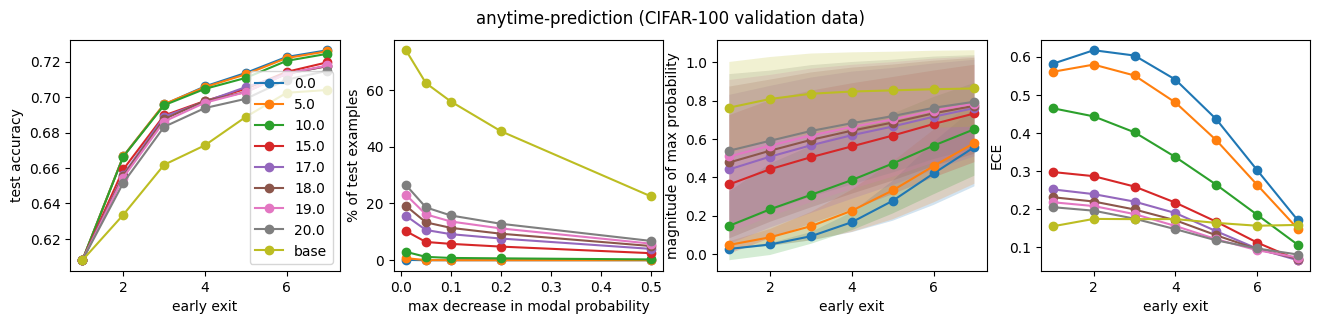

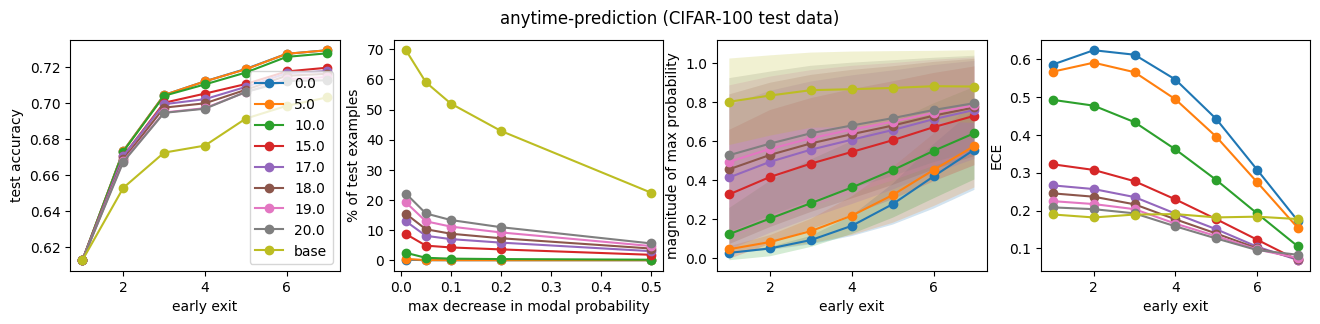

In [13]:
for _logits, _targets, _dict, _label in zip([logits_val, logits_test], [targets_val, targets_test], [C_dict_val, C_dict_test_w_log_reg_val], ['validation', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)
    

In [14]:
# C = 18 yields best ECE while not impacting accuracy and monotonicity too much
C_val = 18.

probs_pa_adapt_thres, preds_pa_adapt_thres, acc_pa_adapt_thres = C_dict_test_w_log_reg_val[C_val]

## 1.1 paper plot (appendix section on adaptive thresholding)

In [15]:
def temper_probs(probs, T):
    # convert probs to logits
    logits = torch.log(probs)
    # temper logits
    logits_tempered = logits / T
    # convert back to probs
    probs_tempered = torch.softmax(logits_tempered, dim=2)
    return probs_tempered

In [16]:
probs = torch.softmax(logits_test, dim=2)
preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
acc = [(targets_test == preds[i]).sum() / len(targets_test) for i in range(L)]

T = 1.
probs_pa = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits_test, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T))
preds_pa = {i: torch.argmax(probs_pa, dim=2)[i, :] for i in range(L)}
acc_pa = [(targets_test == preds_pa[i]).sum() / len(targets_test) for i in range(L)]

T = 1.
probs_pa_5 = torch.tensor(f_probs_ovr_poe_logits_weighted_generalized(logits_test, weights=(np.arange(1, L + 1, 1, dtype=float) / L) * T, threshold=5.))
preds_pa_5 = {i: torch.argmax(probs_pa_5, dim=2)[i, :] for i in range(L)}
acc_pa_5 = [(targets_test == preds_pa_5[i]).sum() / len(targets_test) for i in range(L)]

probs_pa_tempered = temper_probs(probs_pa, np.array([0.20, 0.25 ,0.30, 0.35, 0.4, 0.45, 0.5])[:, None, None]).to(torch.float32)
preds_pa_tempered = {i: torch.argmax(probs_pa_tempered, dim=2)[i, :] for i in range(L)}
acc_pa_tempered = [(targets_test == preds_pa_tempered[i]).sum() / len(targets_test) for i in range(L)]

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:288: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2)


In [17]:
import matplotlib 

text_width = 5.50107 # in  --> Confirmed with template explanation
dpi = 300

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1, dpi=dpi, autolayout=True)  # fontsize of the figure 
matplotlib.rc('lines', linewidth=1, markersize=3)
matplotlib.rc('savefig', dpi=1200, bbox='tight')
matplotlib.rc('grid', alpha=0.3)
matplotlib.rc('axes', grid=True)

matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
# matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

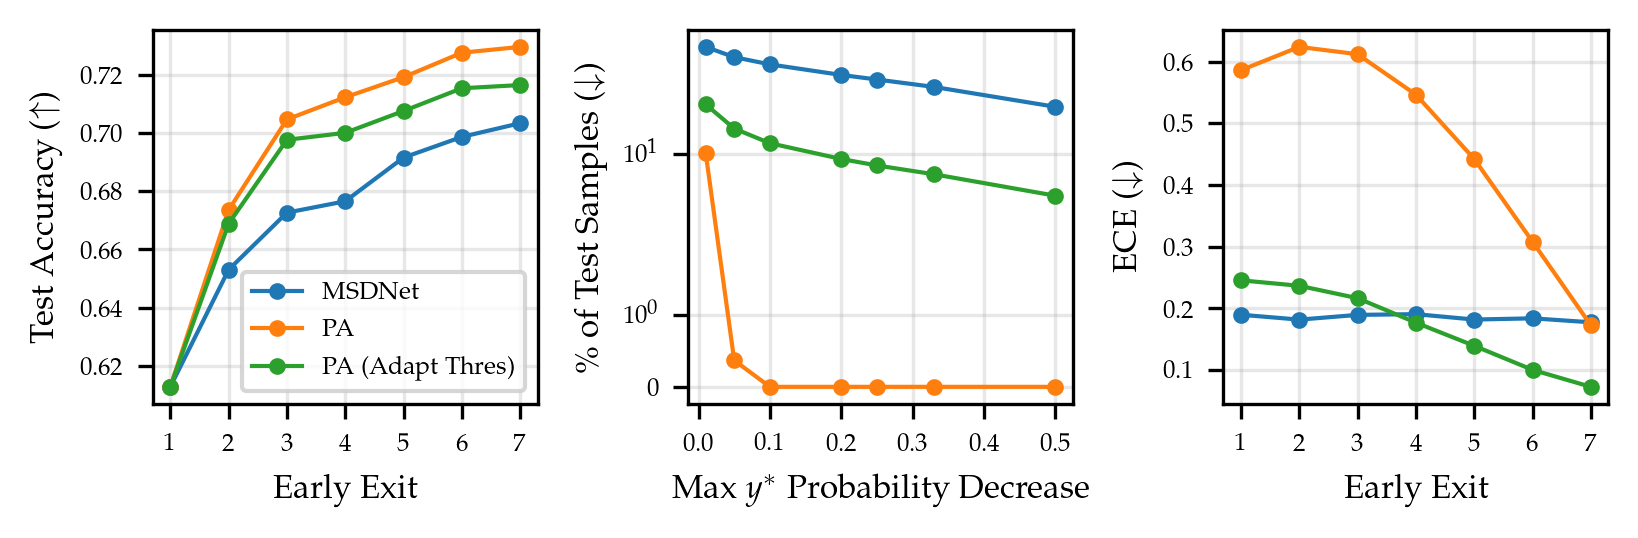

In [20]:
THRESHOLDS = [-0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5]

BASE_MODEL = 'MSDNet'
RES_DICT = {'MSDNet': (probs, preds, acc),
            f'PA': (probs_pa, preds_pa, acc_pa),
            # f'PA (temp)': (probs_pa_tempered, preds_pa_tempered, acc_pa_tempered),
            f'PA (Adapt Thres)': (probs_pa_adapt_thres, preds_pa_adapt_thres, acc_pa_adapt_thres),
            # f'PA (thres=5)': (probs_pa_5, preds_pa_5, acc_pa_5)
}

early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width/3))
for label, arrs in RES_DICT.items():
    _probs, _preds, _acc = arrs
    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    
    # modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N, thresholds=THRESHOLDS)
    modal_probs = modal_probs_decreasing(targets_test, _probs, layer=None, N=N, thresholds=THRESHOLDS)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)


    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), _targets.numpy()))
    ax[2].plot(early_exits, ece, marker='o', label=label)

ax[1].set_xlabel('Max $y^*$ Probability Decrease ')
ax[1].set_yscale('symlog')
ax[1].set_ylabel('\% of Test Samples ($\downarrow$)')
# ax[1].set_xticks([-x for x in THRESHOLDS])
ax[1].set_xticks([0., 0.1, 0.2, 0.3, 0.4, 0.5])

ax[2].set_xlabel('Early Exit')
ax[2].set_ylabel('ECE ($\downarrow$)')
ax[2].set_xticks(early_exits)

ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('Test Accuracy ($\\uparrow$)')
ax[0].set_xlabel('Early Exit')
ax[0].set_xticks(early_exits)

# plt.suptitle(f'anytime-prediction ({dataset} {_label} data)')
plt.savefig(f'figures/figure_adapt_thres_appendix.pdf', bbox_inches='tight')
plt.show()

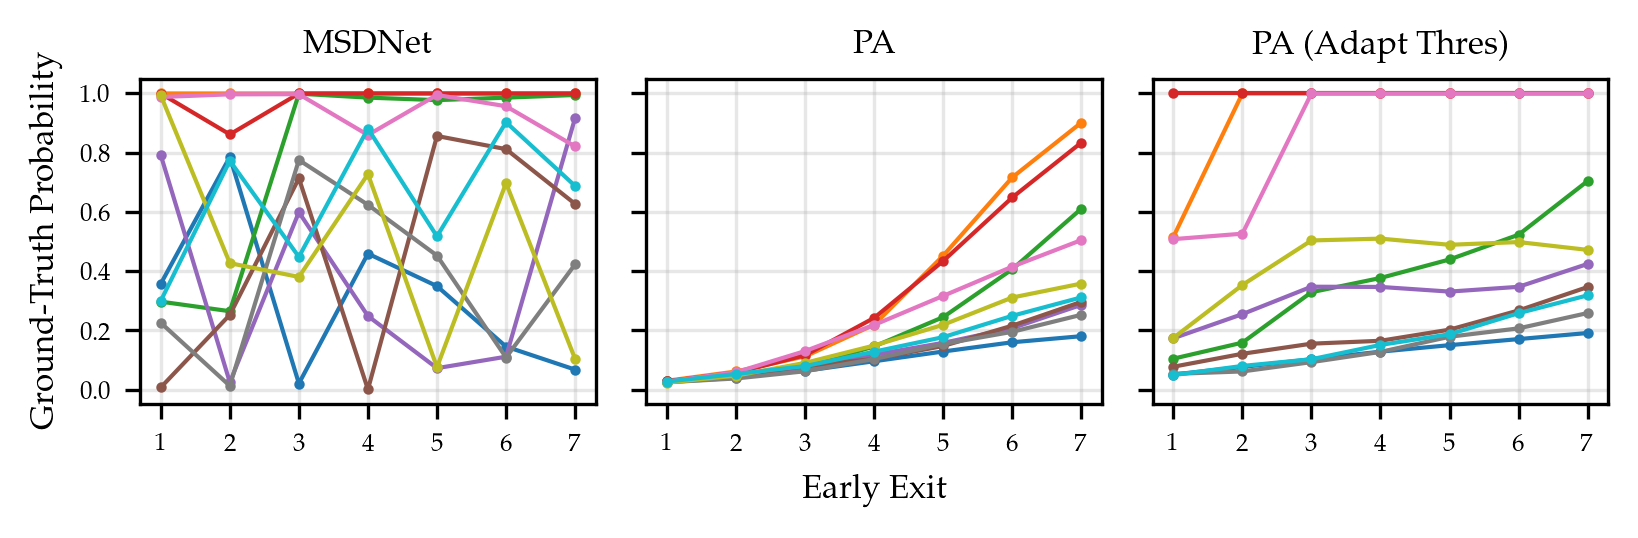

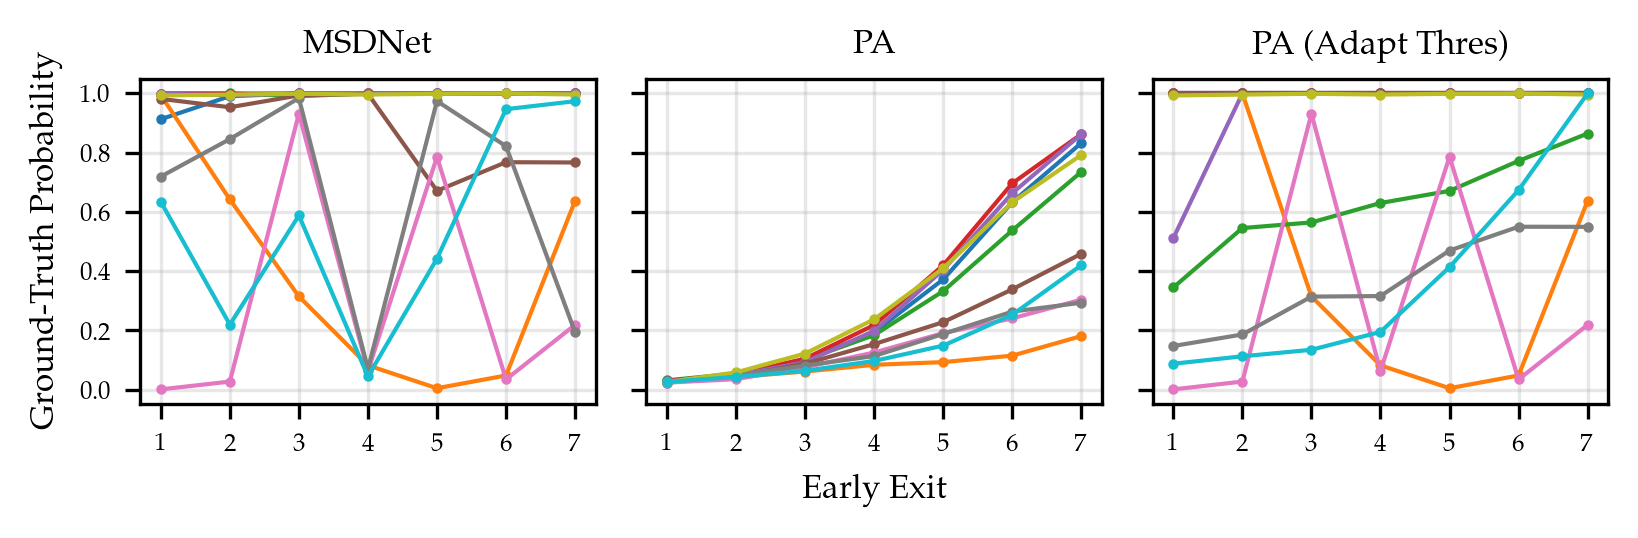

In [37]:
# set random seed
random.seed(15)

for j in range(2):
    fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width/3), sharey=True)
    samples = random.sample(range(10000), 10)
    for i in samples:
        # probs_i = probs_pa[:, i, preds_pa[L - 1][i]].cpu()
        # probs_adapt_thres_i = probs_pa_adapt_thres[:, i, preds_pa_adapt_thres[L - 1][i]].cpu()
        # probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        probs_i = probs_pa[:, i, targets_test[i]].cpu()
        probs_adapt_thres_i = probs_pa_adapt_thres[:, i, targets_test[i]].cpu()
        probs_i_baseline = probs[:, i, targets_test[i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}', marker='o', ms=1.5);
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}', marker='o', ms=1.5);
        ax[2].plot(list(range(1, len(probs_adapt_thres_i) + 1)), probs_adapt_thres_i, label=f'{i}', marker='o', ms=1.5);

    ax[0].set_title('MSDNet')
    ax[1].set_title('PA')
    ax[2].set_title('PA (Adapt Thres)')
    ax[0].set_ylabel('Ground-Truth Probability')
    
    ax[1].set_xlabel('Early Exit')
    ax[0].set_xticks(early_exits)
    ax[1].set_xticks(early_exits)
    ax[2].set_xticks(early_exits)

    plt.savefig(f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/figures/figure_prob_trajectories_appendix_{j}.pdf')

    plt.show()

In [26]:
THRES = [0., 1., 3., 5., 7.]

thres_dict = {}
for thres in tqdm(THRES):
    _probs = torch.tensor(f_probs_ovr_poe_logits_weighted(logits_test, threshold=thres))
    _preds = {i: torch.argmax(_probs, dim=2)[i, :] for i in range(L)}
    _acc = [(targets_test == _preds[i]).sum() / len(targets_test) for i in range(L)]
    _modal_probs = modal_probs_decreasing(_preds, _probs, L, N=N)

    groud_truth_coverage = {l: 0 for l in range(L)}
    predictive_set_size = {l: [] for l in range(L)}
    for l in range(L):
        for n in range(N):
            if _probs[l, n, targets_test[n]] > 0.:
                groud_truth_coverage[l] += 1
            predictive_set_size[l].append((_probs[l, n, :] > 0).sum())

    predictive_set_size = {l: torch.stack(sizes, dim=0) for l, sizes in predictive_set_size.items()}
    predictive_set_size_mean = {l: sizes.numpy().mean() for l, sizes in predictive_set_size.items()}
    groud_truth_coverage_pct = {l: (x / N) for l, x in groud_truth_coverage.items()}
    thres_dict[thres] = (groud_truth_coverage_pct, predictive_set_size_mean, _acc, _modal_probs)

 60%|██████    | 3/5 [00:18<00:12,  6.36s/it]/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:152: RuntimeWarning: invalid value encountered in divide
  probs = probs / np.repeat(probs.sum(axis=2)[:, :, np.newaxis], C, axis=2)
100%|██████████| 5/5 [00:32<00:00,  6.41s/it]


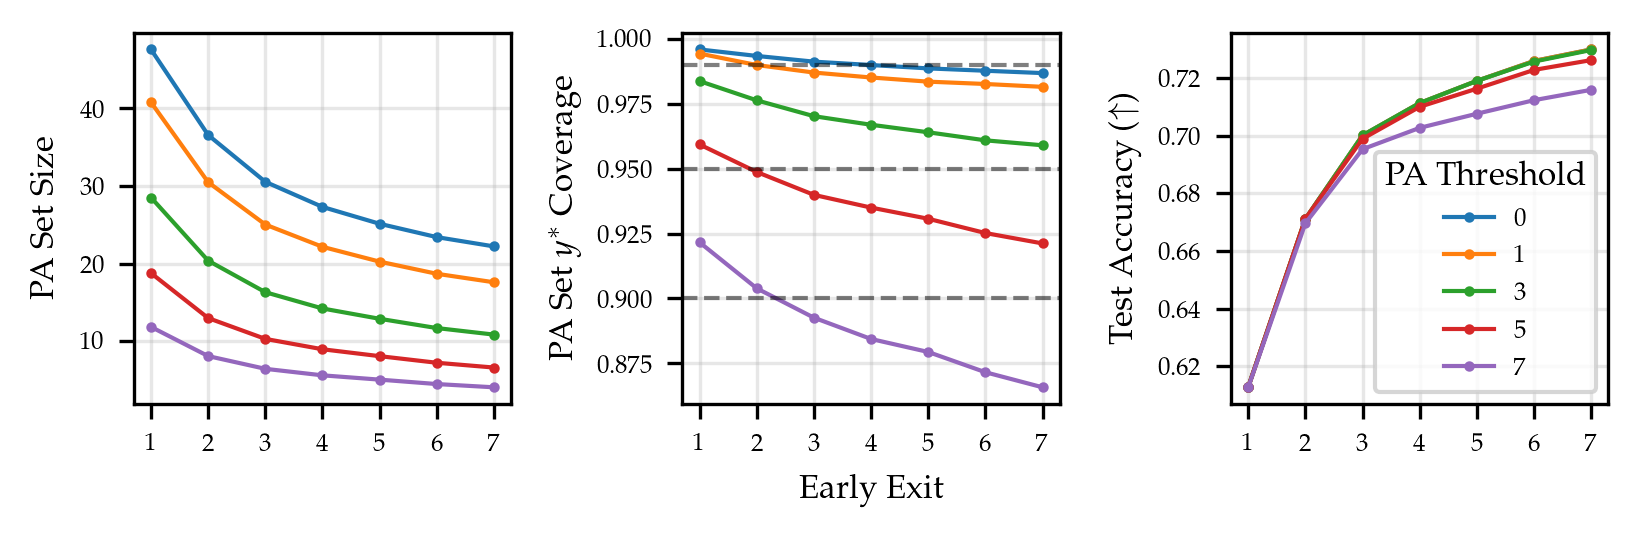

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(text_width, text_width/3))
for thres in THRES:
    ax[0].plot([x + 1 for x in thres_dict[thres][1].keys()], list(thres_dict[thres][1].values()), marker='o', ms=1.5, label=int(thres))
    ax[1].plot([x + 1 for x in thres_dict[thres][0].keys()], list(thres_dict[thres][0].values()), marker='o', ms=1.5, label=int(thres))
    ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], thres_dict[thres][2], marker='o', ms=1.5, label=int(thres))
    # ax[3].plot(thres_dict[thres][3].keys(), thres_dict[thres][3].values(), label=thres)
# ax[2].plot([x + 1 for x in thres_dict[thres][0].keys()], acc, label='MSDNet', linestyle='--')
# _modal_probs = modal_probs_decreasing(preds, probs, L)
# ax[3].plot(_modal_probs.keys(), _modal_probs.values(), label='MSDNets', linestyle='--')
ax[2].legend(title='PA Threshold')
# ax[2].legend(title='logits threshold')
ax[0].set_ylabel('PA Set Size')
ax[1].set_ylabel('PA Set $y^*$ Coverage')
ax[2].set_ylabel('Test Accuracy ($\\uparrow$)')
# ax[0].set_xlabel('early exit')
ax[1].set_xlabel('Early Exit')
# ax[2].set_xlabel('early exit')
# ax[3].set_xlabel('max decrease in modal probability')
# ax[3].set_ylabel('% of test examples')
ax[0].set_xticks(early_exits)
ax[1].set_xticks(early_exits)
ax[2].set_xticks(early_exits)

ax[1].axhline(y=0.99, color='black', linestyle='--', alpha=0.5)
ax[1].axhline(y=0.95, color='black', linestyle='--', alpha=0.5)
ax[1].axhline(y=0.90, color='black', linestyle='--', alpha=0.5)
# plt.suptitle(ARGS.data)
plt.savefig(f'/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/figures/figure_pa_pred_sets_appendix.pdf')
plt.show()

## 2 Logistic Regression on train data

In [12]:
log_reg_train = fit_log_reg(logits_train, targets_train)

/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/utils_notebook.py:803: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_K_logits, _ = torch.topk(torch.tensor(logits[l]), K, dim=1)


In [13]:
C_dict_train = grid_search_adapt_thres(logits_train, targets_train, log_reg_train)
C_dict_test_w_log_reg_train = grid_search_adapt_thres(logits_test, targets_test, log_reg_train)

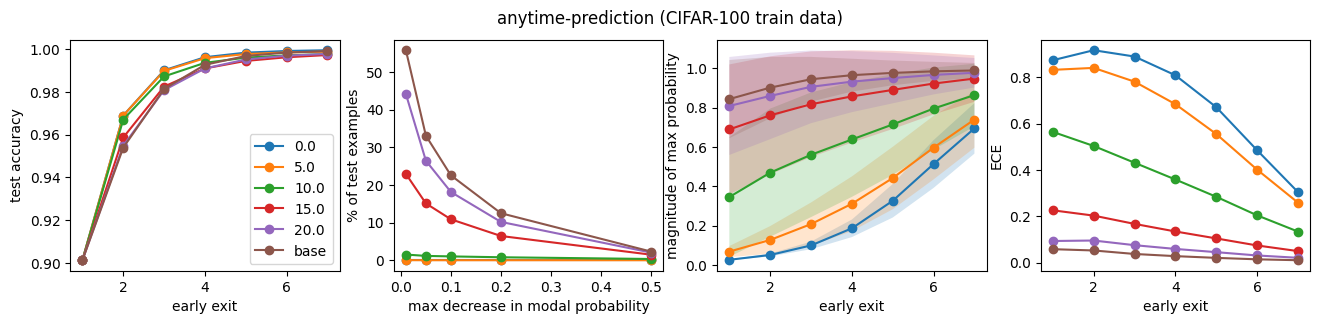

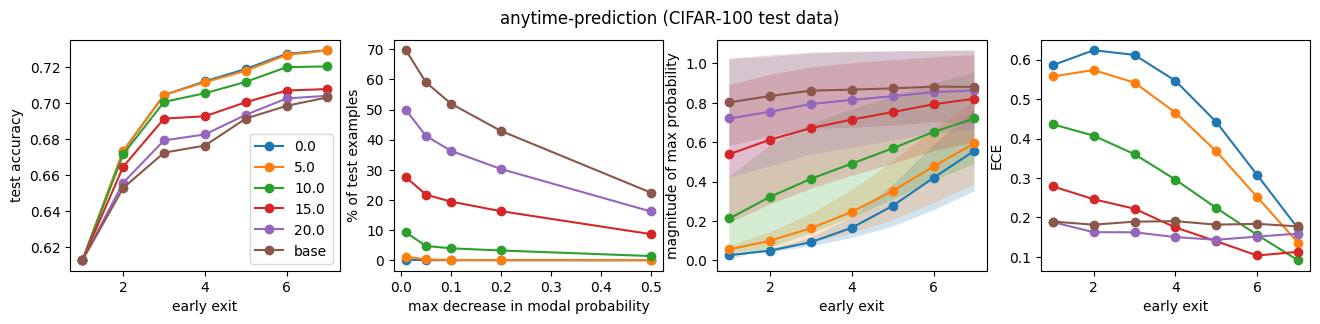

In [14]:
for _logits, _targets, _dict, _label in zip([logits_train, logits_test], [targets_train, targets_test], [C_dict_train, C_dict_test_w_log_reg_train], ['train', 'test']):
    plot_adapt_thres(_logits, _targets, _dict, _label)

In [15]:
# C = 15 yields best ECE while not impacting accuracy and monotonicity too much
C_train = 10.

probs_poe_ovr_adapt_thres_log_reg_train, preds_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train = C_dict_test_w_log_reg_train[C_train]

## 3 Simple binary adaptive thresholding

In [16]:
# CIFAR-10
# probs_poe_ovr_break_ties_generalized_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits[:, n, :], weights=(np.arange(1, L + 1, 1, dtype=float) / L), thres_metric=5, thres_easy=6)) for n in range(N)], axis=1)

# CIFAR-100
probs_poe_ovr_adapt_thres = np.concatenate([np.nan_to_num(get_probs_ovr_poe_w_adaptive_threshold(logits=logits_test[:, n, :], 
                                                                                                 weights=(np.arange(1, L + 1, 1, dtype=float) / L))) for n in range(N)], 
                                                                                                 axis=1)

probs_poe_ovr_adapt_thres = torch.tensor(probs_poe_ovr_adapt_thres)
preds_poe_ovr_adapt_thres = {i: torch.argmax(probs_poe_ovr_adapt_thres, dim=2)[i, :] for i in range(L)}
acc_poe_ovr_adapt_thres = [(targets_test == preds_poe_ovr_adapt_thres[i]).sum() / len(targets_test) for i in range(L)]

## 4 Summary Adaptive Thresholds

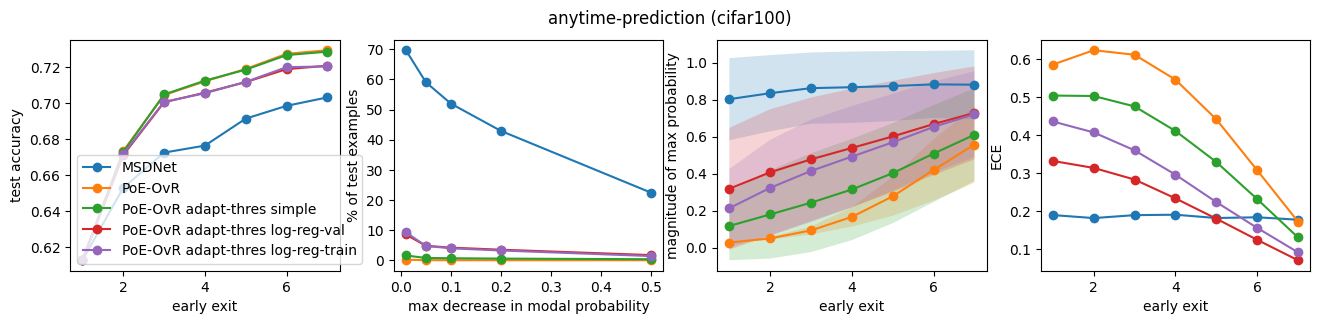

In [17]:
L, N = len(logits_test), len(targets_test)
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 4, figsize=(16, 3))


for _preds, _probs, _acc, label in [
                            (preds, probs, acc, 'MSDNet'),
                            (preds_poe_ovr, probs_poe_ovr, acc_poe_ovr, 'PoE-OvR'),
                            (preds_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres, acc_poe_ovr_adapt_thres, 'PoE-OvR adapt-thres simple'),
                            (preds_poe_ovr_adapt_thres_log_reg_val, probs_poe_ovr_adapt_thres_log_reg_val, acc_poe_ovr_adapt_thres_log_reg_val, 'PoE-OvR adapt-thres log-reg-val'),
                            (preds_poe_ovr_adapt_thres_log_reg_train, probs_poe_ovr_adapt_thres_log_reg_train, acc_poe_ovr_adapt_thres_log_reg_train, 'PoE-OvR adapt-thres log-reg-train'),
                            ]:

    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    modal_probs = modal_probs_decreasing(_preds, _probs, layer=L, N=N)
    ax[1].plot(modal_probs.keys(), modal_probs.values(), marker='o', label=label)

    mean_magnitude, std_magnitude = _probs.max(2).values.mean(1), _probs.max(2).values.std(1)

    ax[2].plot(early_exits, mean_magnitude, marker='o', label=label)
    ax[2].fill_between(early_exits, mean_magnitude - std_magnitude, mean_magnitude + std_magnitude, alpha=0.2)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets_test.numpy()))
    ax[3].plot(early_exits, ece, marker='o', label=label)


ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples')

ax[2].set_xlabel('early exit')
ax[2].set_ylabel('magnitude of max probability')

ax[3].set_xlabel('early exit')
ax[3].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

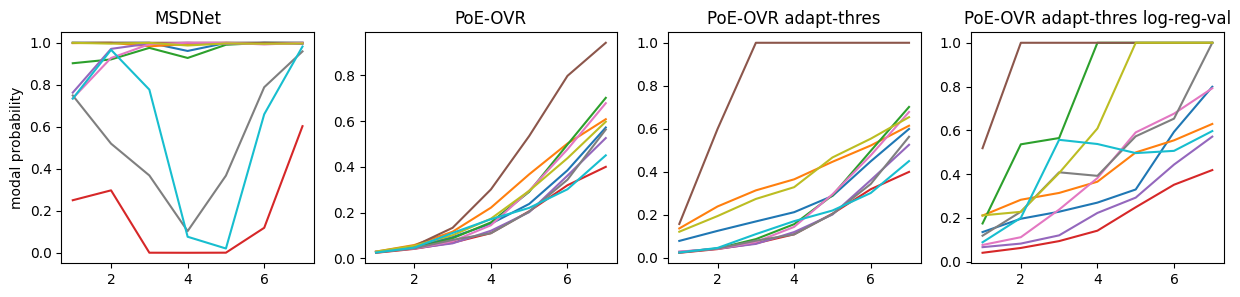

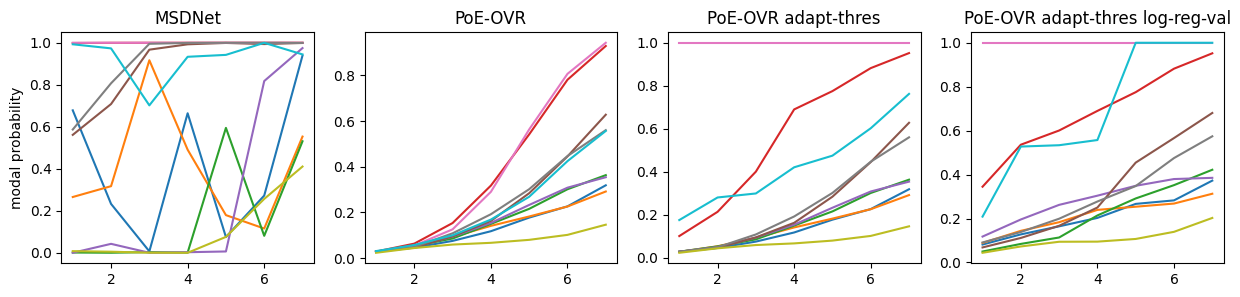

In [18]:
for _ in range(2):
    fig, ax = plt.subplots(1, 4, figsize=(15, 3))
    samples = random.sample(range(10000), 10)
    for i in samples:
        probs_i = probs_poe_ovr[:, i, preds_poe_ovr[L - 1][i]].cpu()
        probs_adapt_thres_i = probs_poe_ovr_adapt_thres[:, i, preds_poe_ovr_adapt_thres[L - 1][i]].cpu()
        probs_adapt_thres_log_reg_val_i = probs_poe_ovr_adapt_thres_log_reg_val[:, i, preds_poe_ovr_adapt_thres_log_reg_val[L - 1][i]].cpu()
        probs_i_baseline = probs[:, i, preds[L - 1][i]].cpu()
        ax[0].plot(list(range(1, len(probs_i_baseline) + 1)), probs_i_baseline, label=f'{i}');
        ax[1].plot(list(range(1, len(probs_i) + 1)), probs_i, label=f'{i}');
        ax[2].plot(list(range(1, len(probs_adapt_thres_i) + 1)), probs_adapt_thres_i, label=f'{i}');
        ax[3].plot(list(range(1, len(probs_adapt_thres_log_reg_val_i) + 1)), probs_adapt_thres_log_reg_val_i, label=f'{i}');
    # plt.savefig('/home/metod/Desktop/PhD/year1/PoE/MSDNet-PyTorch/modal_probs.pdf')
    # plt.legend()
    ax[0].set_title('MSDNet')
    ax[1].set_title('PoE-OVR')
    ax[2].set_title('PoE-OVR adapt-thres')
    ax[3].set_title('PoE-OVR adapt-thres log-reg-val')
    ax[0].set_ylabel('modal probability')
    plt.show()

In [19]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val = {q: [] for q in quantiles}
_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr.max(dim=2).values
_probs_poe_ovr_adapt_thres = probs_poe_ovr_adapt_thres.max(dim=2).values
_probs_poe_ovr_adapt_thres_log_reg_val = probs_poe_ovr_adapt_thres_log_reg_val.max(dim=2).values
for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres[q].append(np.quantile(_probs_poe_ovr_adapt_thres[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val[q].append(np.quantile(_probs_poe_ovr_adapt_thres_log_reg_val[l, :].flatten(), q))

In [20]:
budget_dict_hetero = {name: [] for name in ['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val']}
for name, _thres_arr, _probs in zip(['MSDNet', 'PoE-OVR', 'PoE-OVR adapt-thres', 'PoE-OVR adapt-thres log-reg-val'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe_ovr_adapt_thres, thres_arr_hetero_poe_ovr_adapt_thres_log_reg_val], 
                                    [probs, probs_poe_ovr, probs_poe_ovr_adapt_thres, probs_poe_ovr_adapt_thres_log_reg_val]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets_test).sum() / N), 
                                         np.mean([x[0] for x in _preds_terminated]), 
                                         thres_quantile))

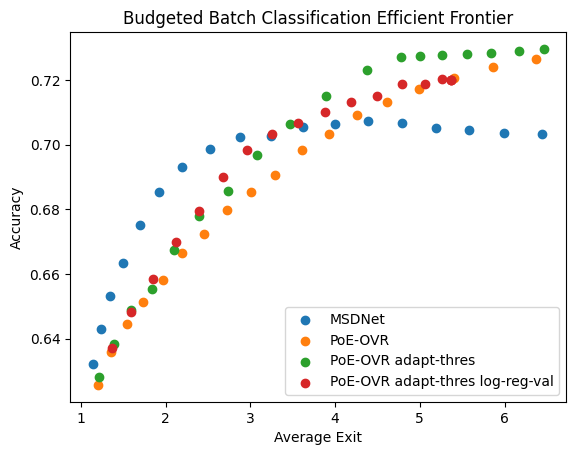

In [21]:
plt.scatter([x[1] for x in budget_dict_hetero['MSDNet']], [x[0] for x in budget_dict_hetero['MSDNet']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR']], [x[0] for x in budget_dict_hetero['PoE-OVR']], label='PoE-OVR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres']], label='PoE-OVR adapt-thres', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], [x[0] for x in budget_dict_hetero['PoE-OVR adapt-thres log-reg-val']], label='PoE-OVR adapt-thres log-reg-val', marker='o')
# plt.scatter([1], [1], label='oracle', marker='o', color='tab:red')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Budgeted Batch Classification Efficient Frontier')
plt.show()

## 5 Ablations for Budgeted Batch Classification

In [6]:
logits_test.shape

torch.Size([5, 50000, 1000])

In [7]:
quantiles = np.arange(0.1, 1., 0.05)

thres_arr_hetero = {q: [] for q in quantiles}
thres_arr_hetero_poe_ovr = {q: [] for q in quantiles}
thres_arr_hetero_poe = {q: [] for q in quantiles}
thres_arr_hetero_ovr = {q: [] for q in quantiles}
thres_arr_hetero_ovr_thres_5 = {q: [] for q in quantiles}
thres_arr_logits_diff = {q: [] for q in quantiles}

_probs = probs.max(dim=2).values
_probs_poe_ovr = probs_poe_ovr.max(dim=2).values
_probs_poe = probs_poe.max(dim=2).values
_probs_ovr = probs_ovr.max(dim=2).values
_probs_ovr_thres_5 = probs_ovr_thres_5.max(dim=2).values

_logits_diff = []
for l in range(L):
    _logits_diff.append(logits_test[l, :, :].max(dim=1).values - logits_test[l, :, :].sort(descending=True)[0][:, 1])
_logits_diff = torch.stack(_logits_diff)

for l in range(L):
    for q in quantiles:
        thres_arr_hetero[q].append(np.quantile(_probs[l, :].flatten(), q))
        thres_arr_hetero_poe_ovr[q].append(np.quantile(_probs_poe_ovr[l, :].flatten(), q))
        thres_arr_hetero_poe[q].append(np.quantile(_probs_poe[l, :].flatten(), q))
        thres_arr_hetero_ovr[q].append(np.quantile(_probs_ovr[l, :].flatten(), q))
        thres_arr_hetero_ovr_thres_5[q].append(np.quantile(_probs_ovr_thres_5[l, :].flatten(), q))
        thres_arr_logits_diff[q].append(np.quantile(_logits_diff[l, :].flatten(), q))

In [8]:
budget_dict_hetero = {name: [] for name in ['MSDNet', 'PoE-OVR', 'PoE', 'OvR', 'logits-diff']}
for name, _thres_arr, _probs in zip(['MSDNet', 'PoE-OVR', 'PoE', 'OvR', 'logits-diff'], 
                                    [thres_arr_hetero, thres_arr_hetero_poe_ovr, thres_arr_hetero_poe, thres_arr_hetero_ovr, thres_arr_logits_diff], 
                                    [probs, probs_poe_ovr, probs_poe, probs_ovr, logits_test]):
    for thres_quantile in _thres_arr.keys():
        _preds_terminated = []
        for n in range(N):
            exited = False
            for l in range(L):
                if name != 'logits-diff':
                    criteria = _probs[l, n, :].max() >= _thres_arr[thres_quantile][l]
                else:
                    criteria = _probs[l, n, :].max() - _probs[l, n, :].sort(descending=True)[0][1] >= _thres_arr[thres_quantile][l]
                
                if criteria:
                    _preds_terminated.append((l+ 1, _probs[l, n, :].argmax()))
                    exited = True
                    break
                
            if not exited:
                _preds_terminated.append((L, _probs[L - 1, n, :].argmax()))
        budget_dict_hetero[name].append((float((torch.stack([x[1] for x in _preds_terminated]) == targets_test).sum() / N), 
                                         np.mean([x[0] for x in _preds_terminated]), 
                                         thres_quantile))

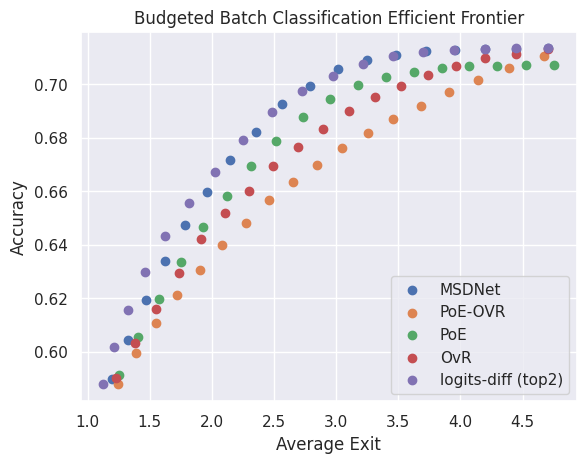

In [11]:
sns.set_theme()

plt.scatter([x[1] for x in budget_dict_hetero['MSDNet']], [x[0] for x in budget_dict_hetero['MSDNet']], label='MSDNet', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE-OVR']], [x[0] for x in budget_dict_hetero['PoE-OVR']], label='PoE-OVR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['PoE']], [x[0] for x in budget_dict_hetero['PoE']], label='PoE', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['OvR']], [x[0] for x in budget_dict_hetero['OvR']], label='OvR', marker='o')
plt.scatter([x[1] for x in budget_dict_hetero['logits-diff']], [x[0] for x in budget_dict_hetero['logits-diff']], label='logits-diff (top2)', marker='o')
plt.xlabel('Average Exit')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Budgeted Batch Classification Efficient Frontier')
plt.show()

## 6 Ranking of sorted IDs analysis

In [43]:
l = 0

logits_sorted_ids = logits_test[l].max(dim=1).values.argsort(descending=True).numpy()
probs_sorted_ids = probs[l].max(dim=1).values.argsort(descending=True).numpy()
probs_ovr_sorted_ids = probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()

assert (preds[l] == preds_ovr[l]).sum() == N

dict_sorted_ids = {'correct': {'softmax': [], 'ovr': []}, 'incorrect': {'softmax': [], 'ovr': []}}
for i, id in enumerate(logits_sorted_ids):
    id_softmax = np.where(probs_sorted_ids == id)[0][0]
    id_ovr = np.where(probs_ovr_sorted_ids == id)[0][0]
    if preds[l][id] == targets_test[id]:
        dict_sorted_ids['correct']['softmax'].append(i - id_softmax)
        dict_sorted_ids['correct']['ovr'].append(i - id_ovr)
    else:
        dict_sorted_ids['incorrect']['softmax'].append(i - id_softmax)
        dict_sorted_ids['incorrect']['ovr'].append(i - id_ovr)

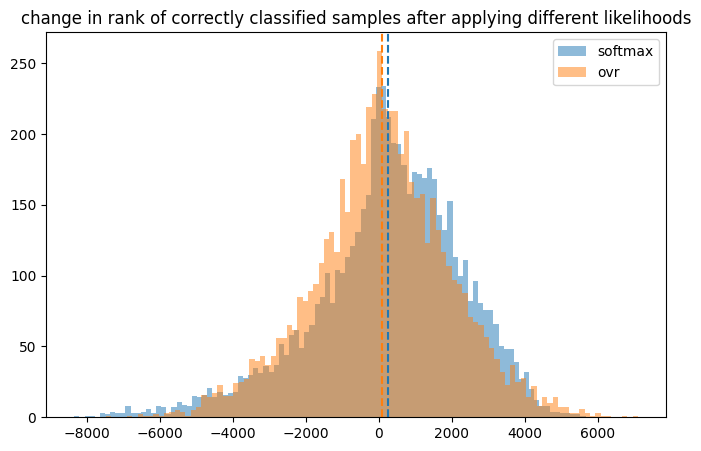

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.hist(dict_sorted_ids['correct']['softmax'], bins=100, label='softmax', alpha=0.5)
plt.hist(dict_sorted_ids['correct']['ovr'], bins=100, label='ovr', alpha=0.5)
plt.axvline(x=np.mean(dict_sorted_ids['correct']['softmax']), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(dict_sorted_ids['correct']['ovr']), color='tab:orange', linestyle='--')
plt.title('change in rank of correctly classified samples after applying different likelihoods')
plt.legend()
plt.show()

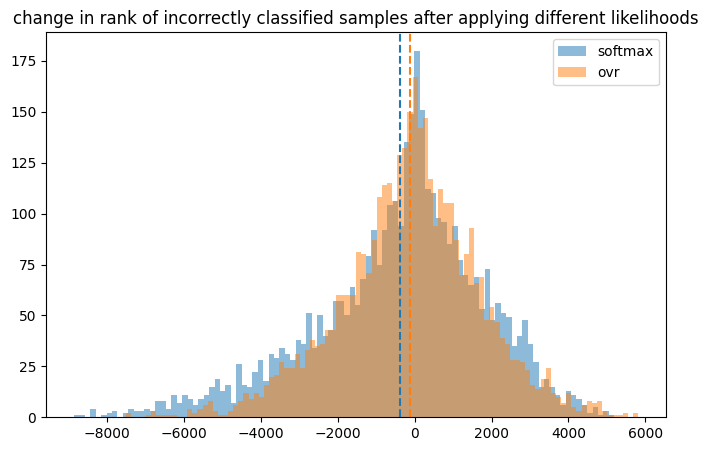

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plt.hist(dict_sorted_ids['incorrect']['softmax'], bins=100, label='softmax', alpha=0.5)
plt.hist(dict_sorted_ids['incorrect']['ovr'], bins=100, label='ovr', alpha=0.5)
plt.axvline(x=np.mean(dict_sorted_ids['incorrect']['softmax']), color='tab:blue', linestyle='--')
plt.axvline(x=np.mean(dict_sorted_ids['incorrect']['ovr']), color='tab:orange', linestyle='--')
plt.title('change in rank of incorrectly classified samples after applying different likelihoods')
plt.legend()
plt.show()

## 7 Impact of likelihood on the sorting of test samples

In [68]:
probs_logits_add_min = logits_test[0] + logits_test[0].min(dim=1).values.abs()[:, None]
probs_logits_add_min = probs_logits_add_min / probs_logits_add_min.sum(dim=1).unsqueeze(1)

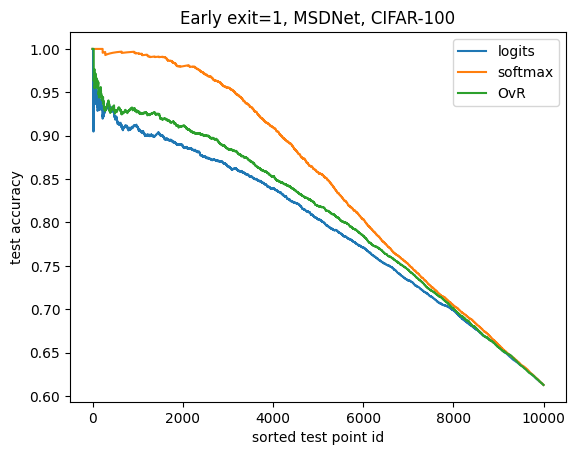

In [95]:
l = 0

plt.plot((targets_test == preds[l])[logits_test[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits')
plt.plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='softmax')
plt.plot((targets_test == preds[l])[probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR')
# plt.plot((targets_test == preds_poe_ovr[l])[probs_poe_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='PoE-OvR')
# plt.plot((targets_test == preds[0])[probs_ovr_thres_5[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR-5')
# plt.plot((targets_test == preds[0])[probs_logits_add_min.max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR-add-min')
# plt.plot(np.linspace(0, 10000, 10000), np.linspace(0, 10000, 10000), label='oracle', color='black', linestyle='--')
# plt.ylim(0, 7000)
plt.xlabel('sorted test point id')
plt.ylabel('test accuracy')
plt.title(f'Early exit={l + 1}, MSDNet, CIFAR-100')
plt.legend()
plt.show()

In [75]:
bucket_arr_prob = []
bucket_arr_ovr = []
for i in range(10):
    bucket_arr_ovr.append((targets_test == preds[0])[probs_ovr[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy()[i * 1000:(i + 1) * 1000].sum() / 1000)
    bucket_arr_prob.append((targets_test == preds[0])[probs[0].max(dim=1).values.argsort(descending=True).numpy()].int().numpy()[i * 1000:(i + 1) * 1000].sum() / 1000)

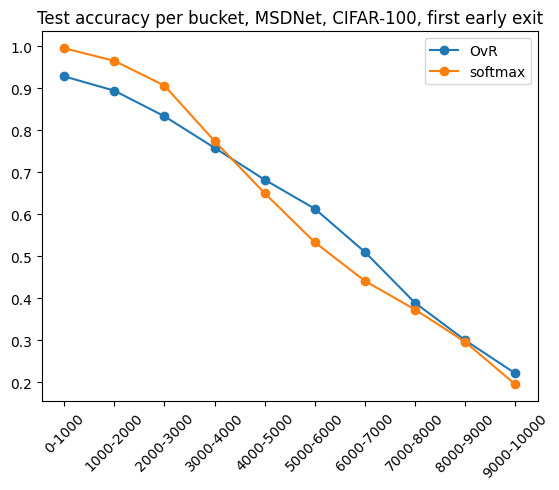

In [76]:
plt.plot(bucket_arr_ovr, label='OvR', marker='o')
plt.plot(bucket_arr_prob, label='softmax', marker='o')
plt.xticks(np.arange(10), [str(i * 1000) + '-' + str((i + 1) * 1000) for i in range(10)])
# rotate xticks
plt.xticks(rotation=45)
plt.title('Test accuracy per bucket, MSDNet, CIFAR-100, first early exit')
plt.legend()
plt.show()

## 8 Calibration and Budgeted Batch Classification

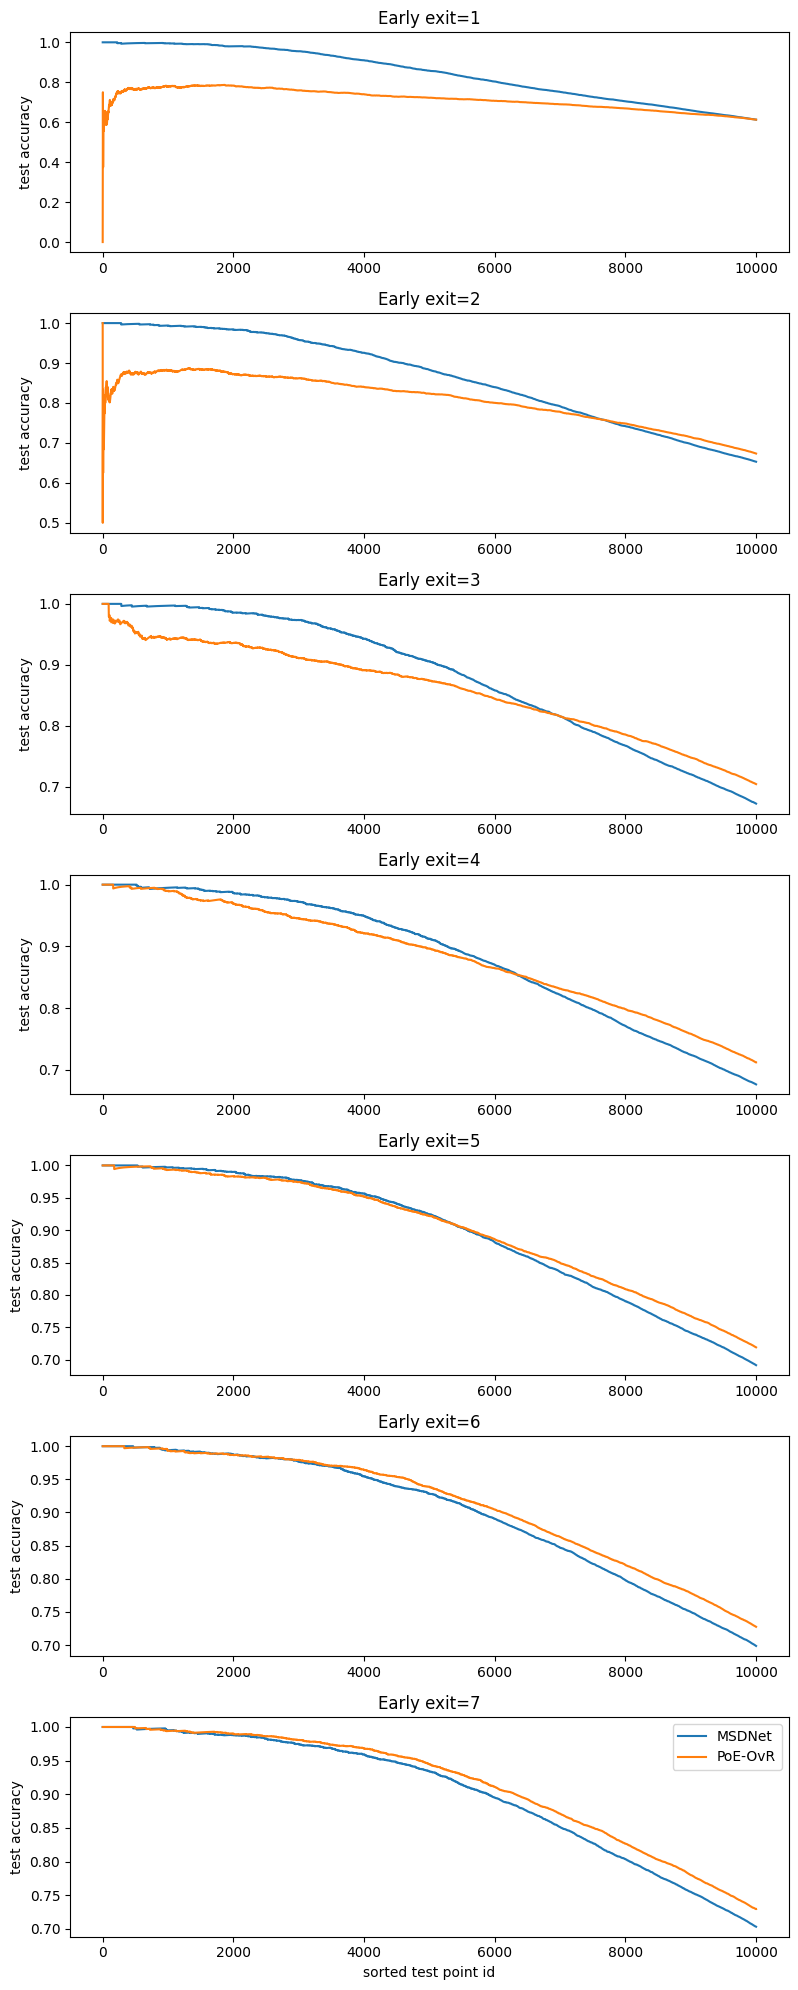

In [102]:
fig, ax = plt.subplots(7, 1, figsize=(8, 20))
for l in range(L):
    ax[l].plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='MSDNet')
    ax[l].plot((targets_test == preds_poe_ovr[l])[probs_poe_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='PoE-OvR')
    ax[l].set_ylabel('test accuracy')
    ax[l].set_title(f'Early exit={l + 1}')
    
plt.xlabel('sorted test point id')
# plt.suptitle('MSDNet vs PoE-OvR, CIFAR-100')
plt.tight_layout()
plt.legend()
plt.show()

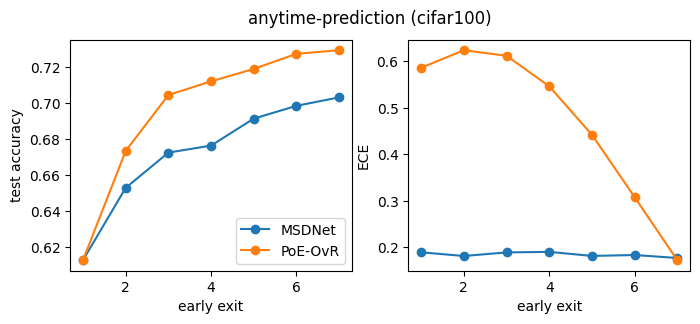

In [104]:
L, N = len(logits_test), len(targets_test)
early_exits = [i + 1 for i in range(L)]
fig, ax = plt.subplots(1, 2, figsize=(8, 3))


for _preds, _probs, _acc, label in [
                            (preds, probs, acc, 'MSDNet'),
                            (preds_poe_ovr, probs_poe_ovr, acc_poe_ovr, 'PoE-OvR'),
                            ]:

    ax[0].plot(early_exits, _acc, label=label, marker='o',)

    ece = []
    for l in range(L):
        ece.append(ECE(bins=15).measure(_probs[l, :, :].numpy(), targets_test.numpy()))
    ax[1].plot(early_exits, ece, marker='o', label=label)


ax[0].legend()
# ax[0].set_title('anytime-prediction')
ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit')

ax[1].set_xlabel('early exit')
ax[1].set_ylabel('ECE')


plt.suptitle(f'anytime-prediction ({ARGS.data})')
plt.show()

## 9 Ratio of top logit vs the rest for different likelihoods

In [180]:
relu = nn.ReLU()

In [101]:
correct = [i for i in range(len(targets_test)) if targets_test[i] == preds[0][i]]
incorrect = [i for i in range(len(targets_test)) if targets_test[i] != preds[0][i]]

In [102]:
len(correct) + len(incorrect)

10000

In [103]:
ratio_dict = {'correct': {'softmax': [], 'ovr': []}, 'incorrect': {'softmax': [], 'ovr': []}}

for pred_type, pred_ids in zip(['correct', 'incorrect'], [correct, incorrect]):
    for prob_type in ['softmax', 'ovr']:
        prob_ground_truth = []
        prob_rest = []
        for n in pred_ids:
            # label = targets_test[n]
            label = preds[0][n]
            rest = [c for c in range(100) if c != label]
            if prob_type == 'softmax':
                prob_ground_truth.append(float(logits_test[0, n, label].exp()))
                prob_rest.append(float(logits_test[0, n, rest].exp().sum()))
            else:
                prob_ground_truth.append(float(relu(logits_test[0, n, label])))
                prob_rest.append(float(relu(logits_test[0, n, rest]).sum()))
        ratio_dict[pred_type][prob_type] = [x for x in zip(prob_ground_truth, prob_rest)]

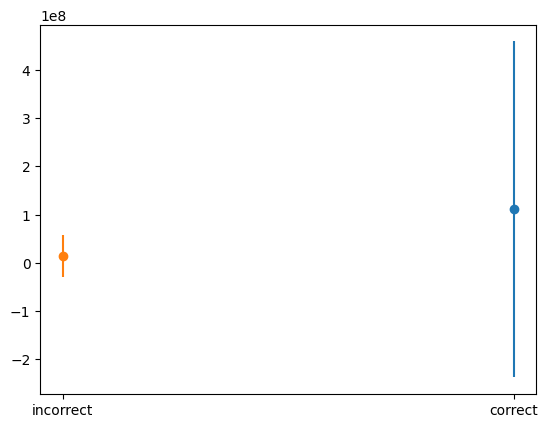

In [124]:
# LIKELIHOOD = 'ovr'
LIKELIHOOD = 'softmax'

arr_incorrect = np.array([x[1] for x in ratio_dict['incorrect'][LIKELIHOOD]])
arr_correct = np.array([x[1] for x in ratio_dict['correct'][LIKELIHOOD]])

arr_incorrect = np.sort(arr_incorrect)
arr_correct = np.sort(arr_correct)

# remove values over 90th percentile
alpha = 90
arr_incorrect = arr_incorrect[arr_incorrect < np.percentile(arr_incorrect, alpha)]
arr_correct = arr_correct[arr_correct < np.percentile(arr_correct, alpha)]

plt.errorbar(1.5, arr_correct.mean(), yerr=arr_correct.std(), label='correct', marker='o')
plt.errorbar(1., arr_incorrect.mean(), yerr=arr_incorrect.std(), label='incorrect', marker='o')
plt.xticks([1, 1.5], ['incorrect', 'correct'])
plt.show()


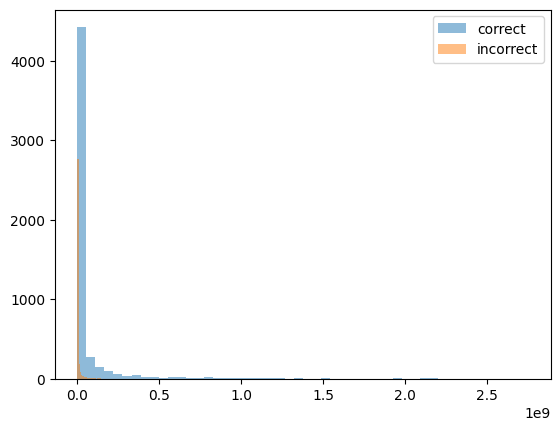

In [125]:
plt.hist(arr_correct, bins=50, label='correct', alpha=0.5)
plt.hist(arr_incorrect, bins=50, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

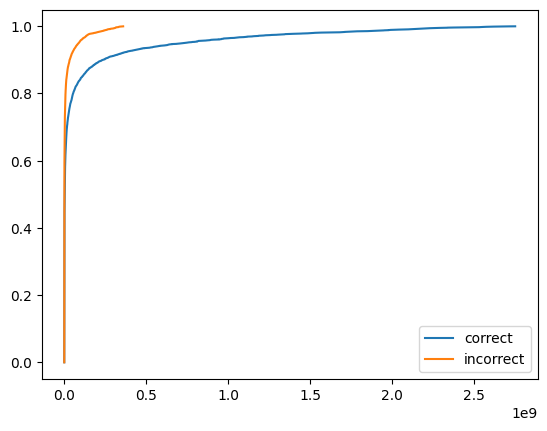

In [126]:
plt.plot(arr_correct, np.linspace(0, 1, len(arr_correct), endpoint=False), label='correct')
plt.plot(arr_incorrect, np.linspace(0, 1, len(arr_incorrect), endpoint=False), label='incorrect')
plt.legend()
plt.show()

## 10 Impact of top logits

In [35]:
relu = nn.ReLU()

In [86]:
l = 0

ranking_softmax = probs[l].max(dim=1).values.argsort(descending=True).numpy()
ranking_ovr = probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()
ranking_top_2_logits = (logits_test[l, :, :].max(dim=1).values - logits_test[l, :, :].sort(descending=True)[0][:, 1]).argsort(descending=True).numpy()
correct_mask = targets_test == preds[l]

In [87]:
(correct_mask)[ranking_softmax][:50]

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True])

In [88]:
ranking_softmax[:50]

array([  75, 1963, 9690, 1975, 7668, 2688,  749,  734, 8128, 7604, 8925,
       9361, 8378, 1971, 4106, 8382, 8453, 7618,  281, 3671, 2058, 7493,
       6512,  621,  238, 6516, 4535, 9262, 1784, 9599, 9394,  105, 9207,
       6046, 3804, 1318,   26, 5806, 1856, 9523, 5511,  681,  647,  461,
       4315, 4999, 2037, 8889, 2046, 7367])

In [89]:
(correct_mask)[ranking_ovr][:50]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True,  True,  True,  True,  True])

In [90]:
ranking_ovr[:50]

array([8128, 4106, 6322, 2153,  681, 4858, 2236, 4954, 3671, 5837, 9599,
       1879, 9207, 5429,  889,  714, 1198, 9641, 3546, 3764, 8169,  949,
       3433, 7618, 1797, 7668, 6983, 4916, 3323, 5320, 7896, 8880, 5876,
       2749, 3808, 9867, 9089, 5645, 6548, 3204, 9924, 7493, 2995, 8937,
       8889,  238, 7631, 9678, 7188,  508])

In [91]:
ranking_ovr[26], ranking_ovr[43]

(6983, 8937)

In [92]:
# _id = 6983
_id = 8937
# _id = 8128

In [93]:
(targets_test == preds[l])[_id]

tensor(False)

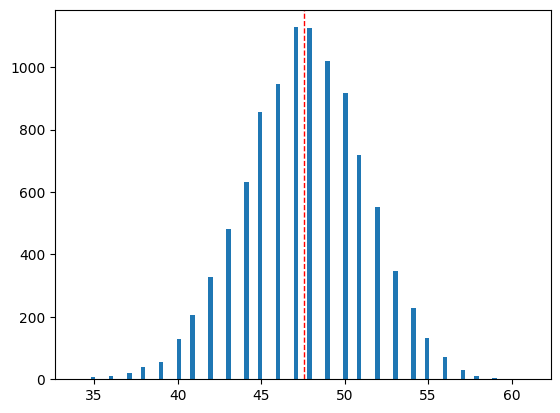

In [94]:
plt.hist((logits_test[l, :, :] > 0).sum(axis=1).numpy(), bins=100)
# add vertical line with mean
plt.axvline((logits_test[l, :, :] > 0).sum(axis=1).numpy().mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

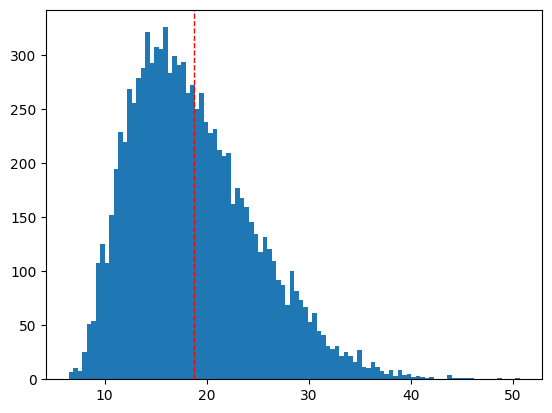

In [95]:
plt.hist(logits_test[l, :, :].max(axis=1).values.numpy(), bins=100)
# add vertical line with mean
plt.axvline(logits_test[l, :, :].max(axis=1).values.numpy().mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [96]:
closer_look_dict = {'correct': {'softmax': [], 'ovr': [], 'top2logits': []}, 'incorrect': {'softmax': [], 'ovr': [], 'top2logits': []}}
for ranking, ranking_type in zip([ranking_ovr, ranking_softmax, ranking_top_2_logits], ['ovr', 'softmax', 'top2logits']):
    incorrect_ids = []
    correct_ids = []
    for i in ranking[:2000]:
        if not correct_mask[i]:
            print(i, np.where(ranking_ovr == i)[0][0], np.where(ranking_softmax == i)[0][0])
            incorrect_ids.append((logits_test[l, i, :].max().item(), (logits_test[l, i, :] > 0).sum().item(), i))
        else:
            correct_ids.append((logits_test[l, i, :].max().item(), (logits_test[l, i, :] > 0).sum().item(), i))
    closer_look_dict['correct'][ranking_type] = correct_ids
    closer_look_dict['incorrect'][ranking_type] = incorrect_ids

6983 26 5516
8937 43 3986
1158 70 5174
3164 89 5615
8483 110 6029
5563 130 7476
3304 132 224
2560 142 2704
9981 182 7895
6768 188 5233
4086 194 4136
2383 204 8510
1631 217 1471
8951 234 1867
1582 235 8693
914 250 6307
9427 251 5900
6479 258 7756
4795 268 7772
3073 279 8156
5094 299 4814
3218 354 5186
8745 359 3492
9320 367 8723
398 374 3478
5919 375 7190
5538 376 6059
3635 384 5396
1357 392 1775
6927 424 1208
8764 453 3090
3582 477 5054
7158 480 7258
8543 481 7654
8097 486 6299
8346 495 7073
7851 496 4412
967 523 6384
8269 535 6229
4747 579 7648
9411 592 4495
2935 600 3064
8823 607 7800
5238 615 8371
6845 626 2636
3021 634 6275
6362 635 5070
7349 638 4743
8398 648 5370
7384 670 2601
3820 688 6151
1541 727 7612
7986 735 1889
7591 741 6531
9309 756 1770
2150 766 5575
894 769 4209
6421 811 1559
9771 846 6813
4776 875 1619
8 880 7167
2863 888 5509
2408 889 6645
808 924 5910
3791 936 9085
3655 937 8412
6137 941 6549
6643 948 2847
6846 955 5704
4141 979 4715
7825 982 7353
1113 983 1633
2877 

In [97]:
len(closer_look_dict['incorrect']['softmax']), len(closer_look_dict['correct']['softmax'])

(40, 1960)

In [98]:
len(closer_look_dict['incorrect']['ovr']), len(closer_look_dict['correct']['ovr'])

(178, 1822)

In [99]:
len(closer_look_dict['incorrect']['top2logits']), len(closer_look_dict['correct']['top2logits'])

(45, 1955)

In [100]:
problematic_ids_ovr = [x[2] for x in closer_look_dict['incorrect']['ovr']]
problematic_ids_softmax = [x[2] for x in closer_look_dict['incorrect']['softmax']]
problematic_ids_top2logits = [x[2] for x in closer_look_dict['incorrect']['top2logits']]

cool_ids_ovr = [x[2] for x in closer_look_dict['correct']['ovr']]
cool_ids_softmax = [x[2] for x in closer_look_dict['correct']['softmax']]
cool_ids_top2logits = [x[2] for x in closer_look_dict['correct']['top2logits']]



In [84]:
problematic_arr_ovr = [x for x in problematic_ids_ovr if x not in problematic_ids_softmax]
problematic_arr_softmax = [x for x in problematic_ids_softmax if x not in problematic_ids_ovr]
problematic_arr_both = [x for x in problematic_ids_softmax if x in problematic_ids_ovr]
cool_arr = [x for x in cool_ids_ovr if x in cool_ids_softmax]
cool_arr_only_softmax = [x for x in cool_ids_softmax if x not in cool_ids_ovr]
len(problematic_arr_ovr), len(cool_arr), len(problematic_arr_softmax), len(problematic_arr_both), len(cool_arr_only_softmax)

(152, 1291, 14, 26, 669)

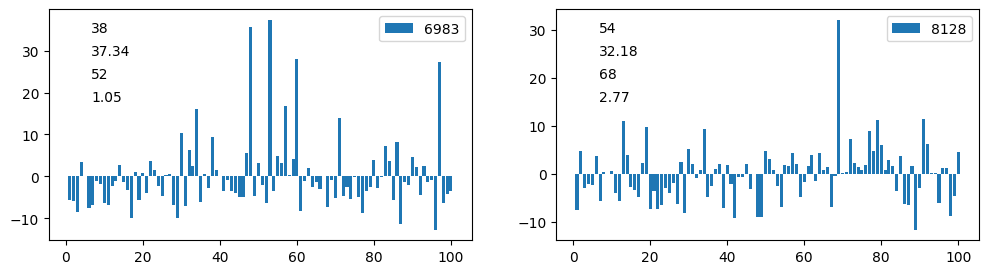

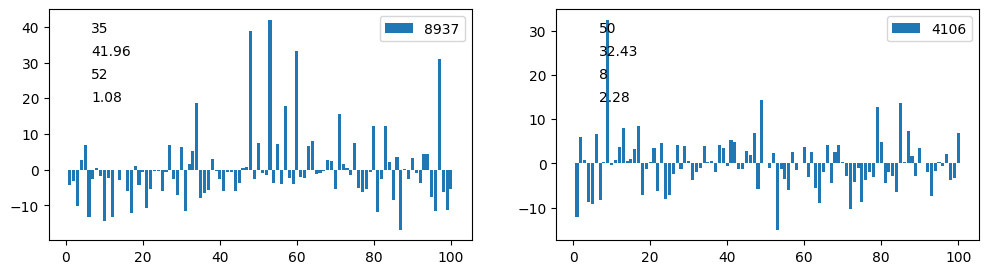

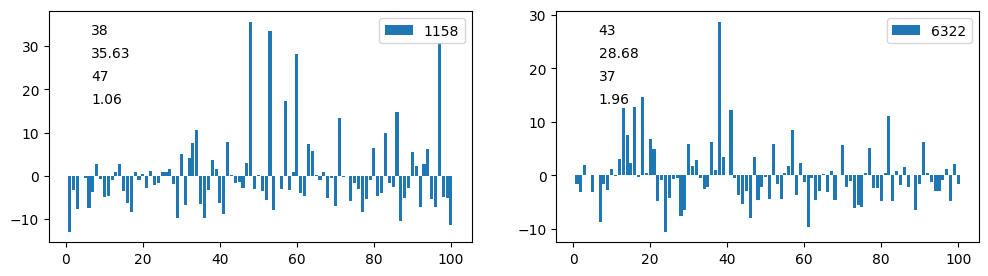

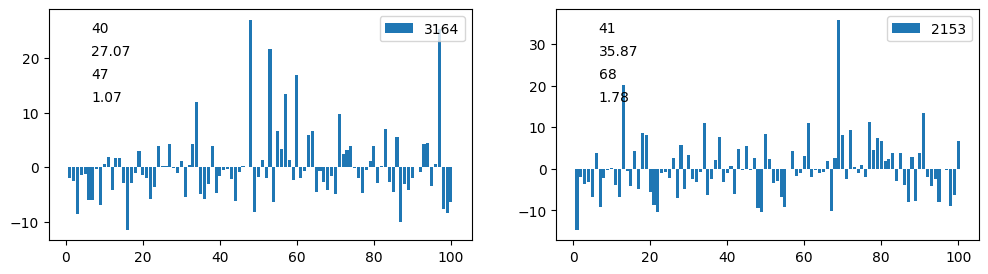

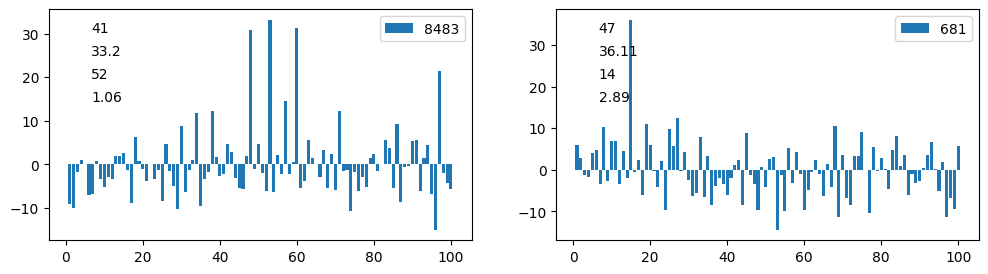

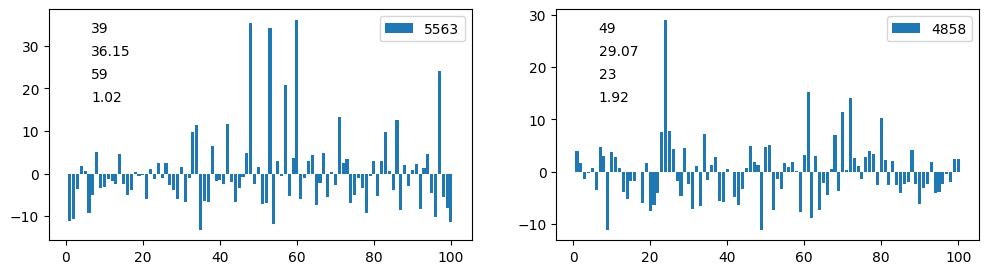

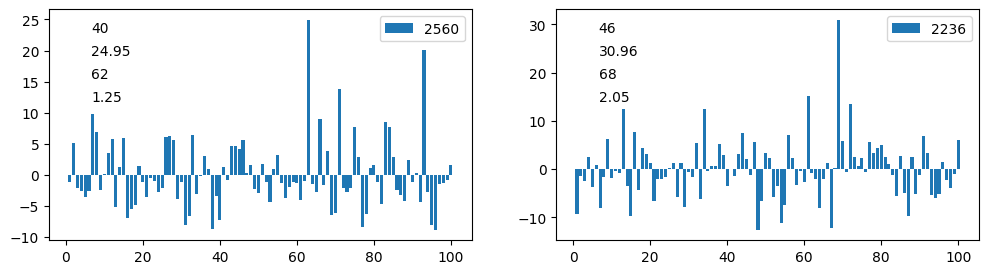

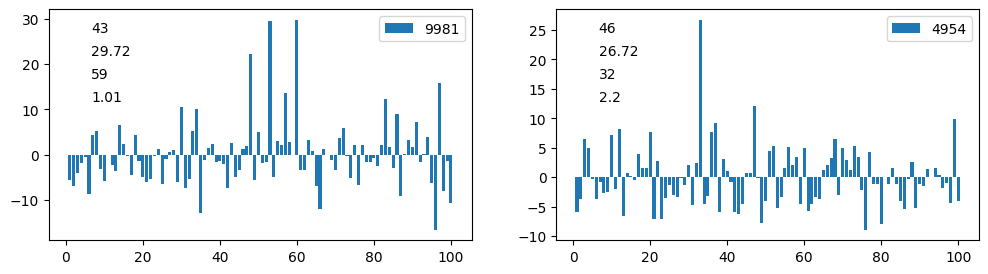

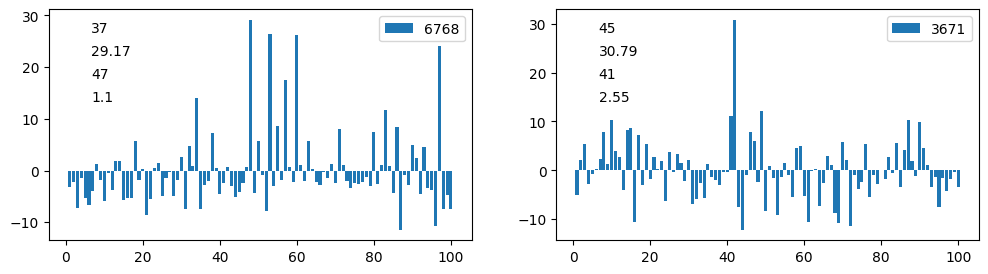

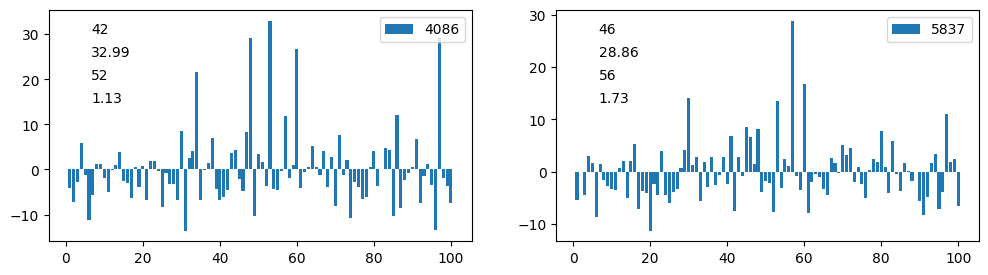

In [64]:
# plot 10 logits from arr and cool_arr side by side
m = 10
# for i, j in zip(problematic_arr_ovr[:m], cool_arr_only_softmax[:m]):
for i, j in zip(problematic_arr_ovr[:m], cool_arr[:m]):
# for i, j in zip(problematic_arr_softmax[:m], cool_arr[:m]):
# for i, n in zip(problematic_arr_both[:m], range(m)):
    # change size of the figure to (10, 5)
    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.bar(np.arange(1, 101, 1), logits_test[l, i, :], label=i)
    # add text box with number of positive logits
    plt.text(0.1, 0.9, (logits_test[l, i, :] > 0).sum().item(), transform=plt.gca().transAxes)
    # add text box with max logits value
    plt.text(0.1, 0.8, round(logits_test[l, i, :].max().item(), 2), transform=plt.gca().transAxes)
    # add text box with argmax
    plt.text(0.1, 0.7, logits_test[l, i, :].argmax().item(), transform=plt.gca().transAxes)
    # add text box with a ratio between top two logits
    plt.text(0.1, 0.6, round(logits_test[l, i, :].max().item() / logits_test[l, i, :].sort(descending=True)[0][1].item(), 2), transform=plt.gca().transAxes)
    plt.legend(loc='upper right')
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(1, 101, 1), logits_test[l, j, :], label=j)
    # add text box with number of positive logits
    plt.text(0.1, 0.9, (logits_test[l, j, :] > 0).sum().item(), transform=plt.gca().transAxes)
    # add text box with max logits value
    plt.text(0.1, 0.8, round(logits_test[l, j, :].max().item(), 2), transform=plt.gca().transAxes)
    # add text box with argmax
    plt.text(0.1, 0.7, logits_test[l, j, :].argmax().item(), transform=plt.gca().transAxes)
    # add text box with a ratio between top two logits
    plt.text(0.1, 0.6, round(logits_test[l, j, :].max().item() / logits_test[l, j, :].sort(descending=True)[0][1].item(), 2), transform=plt.gca().transAxes)
    plt.legend()
    plt.show()

For OvR likelihood, the logits vectors with the following characteristics are problematic:
- the number of positive logits is smaller than average
- the ratio of top 2 logits is small, i.e. the difference between the top logits and the second top logits is small

Moreover, among the problematic points for OvR likelihood in Budgeted Batch Classification, 3 classes are highly prevalent (account for around 50% of problematic points):
- 47 mapple tree
- 52 oak tree
- 96 willow tree

In [27]:
np.unique(preds[l][problematic_arr_ovr], return_counts=True)

(array([ 2,  5,  8,  9, 10, 11, 13, 15, 20, 23, 26, 35, 37, 40, 46, 47, 52,
        54, 57, 58, 59, 60, 61, 62, 68, 70, 71, 73, 77, 78, 81, 90, 92, 94,
        95, 96, 98]),
 array([ 1,  2,  1,  1,  1,  4,  4,  1,  1,  1,  1,  5,  1,  2,  3, 31, 25,
         2,  1,  3,  8,  2,  1,  6,  1,  4,  3,  3,  2,  1,  6,  4,  1,  1,
         1, 10,  7]))

In [28]:
len(preds[l][problematic_arr_ovr])

152

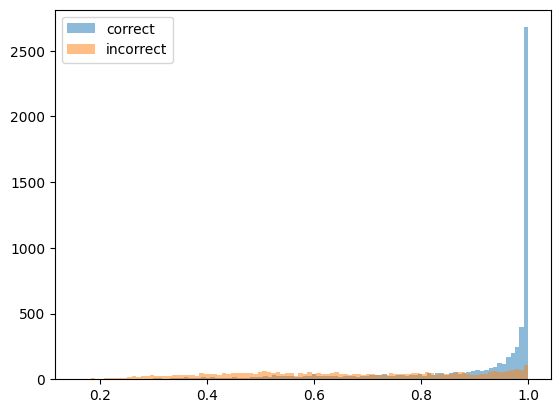

In [29]:
plt.hist(probs[0, correct_mask, :].max(dim=1).values, bins=100, label='correct', alpha=0.5)
plt.hist(probs[0, ~correct_mask, :].max(dim=1).values, bins=100, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

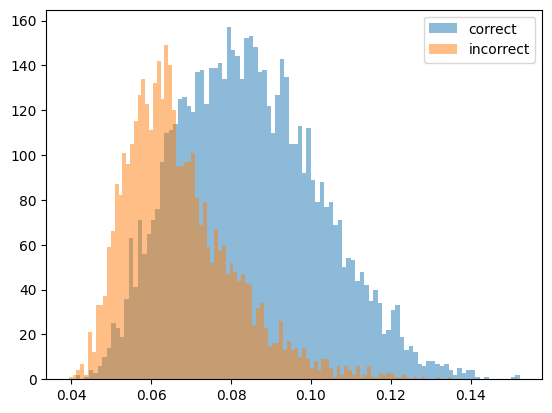

In [30]:
plt.hist(probs_ovr[0, correct_mask, :].max(dim=1).values, bins=100, label='correct', alpha=0.5)
plt.hist(probs_ovr[0, ~correct_mask, :].max(dim=1).values, bins=100, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

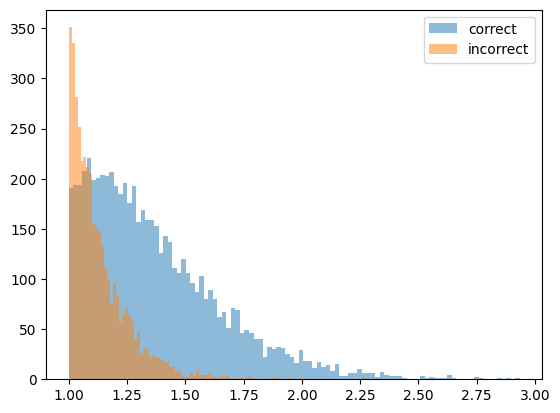

In [31]:
# plot histogram of ratios between top two logits for correct and incorrect predictions
plt.hist(logits_test[l, correct_mask, :].max(dim=1).values / logits_test[l, correct_mask, :].sort(descending=True)[0][:, 1], bins=100, label='correct', alpha=0.5)
plt.hist(logits_test[l, ~correct_mask, :].max(dim=1).values / logits_test[l, ~correct_mask, :].sort(descending=True)[0][:, 1], bins=100, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

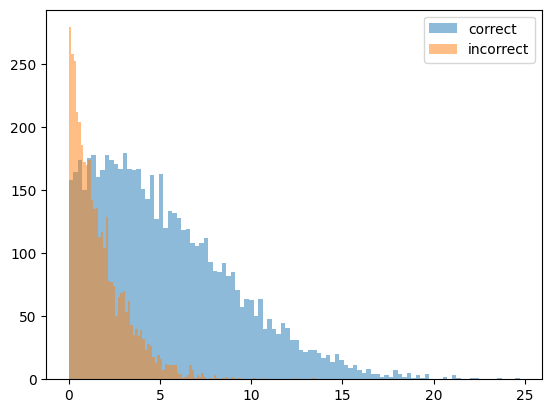

In [32]:
# plot histogram of the difference between top two logits for correct and incorrect predictions
plt.hist(logits_test[l, correct_mask, :].max(dim=1).values - logits_test[l, correct_mask, :].sort(descending=True)[0][:, 1], bins=100, label='correct', alpha=0.5)
plt.hist(logits_test[l, ~correct_mask, :].max(dim=1).values - logits_test[l, ~correct_mask, :].sort(descending=True)[0][:, 1], bins=100, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

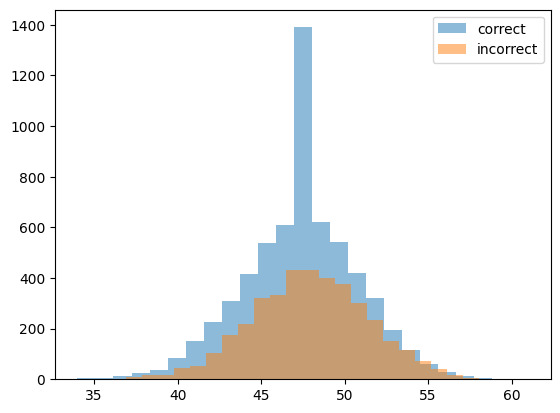

In [33]:
# plot histogram of number of positive logits for correct and incorrect predictions
plt.hist((logits_test[l, correct_mask, :] > 0).sum(dim=1), bins=25, label='correct', alpha=0.5)
plt.hist((logits_test[l, ~correct_mask, :] > 0).sum(dim=1), bins=25, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

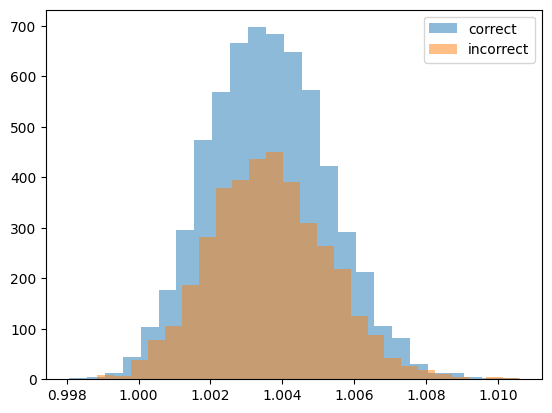

In [36]:
# plot histogram based on the magnitude of positive vs negative logits for each data point

plt.hist(relu(logits_test[l, correct_mask, :]).sum(dim=1) / relu(-logits_test[l, correct_mask, :]).sum(dim=1), bins=25, label='correct', alpha=0.5)
plt.hist(relu(logits_test[l, ~correct_mask, :]).sum(dim=1) / relu(-logits_test[l, ~correct_mask, :]).sum(dim=1), bins=25, label='incorrect', alpha=0.5)
plt.legend()
plt.show()

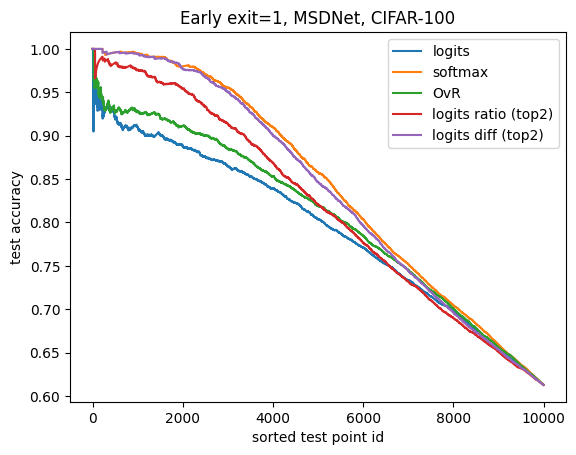

In [135]:
l = 0

plt.plot((targets_test == preds[l])[logits_test[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits')
plt.plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='softmax')
plt.plot((targets_test == preds[l])[probs_ovr[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='OvR')
plt.plot((targets_test == preds[l])[(logits_test[l, :, :].max(dim=1).values / logits_test[l, :, :].sort(descending=True)[0][:, 1]).argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits ratio (top2)')
plt.plot((targets_test == preds[l])[(logits_test[l, :, :].max(dim=1).values - logits_test[l, :, :].sort(descending=True)[0][:, 1]).argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits diff (top2)')
# add based on the ratio between top two logits
plt.xlabel('sorted test point id')
plt.ylabel('test accuracy')
plt.title(f'Early exit={l + 1}, MSDNet, CIFAR-100')
plt.legend()
plt.show()

In [133]:
_logits = torch.zeros(N)
K = 2
for k in range(K):
    _logits += (logits_test[l, :, :].max(dim=1).values - logits_test[l, :, :].sort(descending=True)[0][:, k + 1])

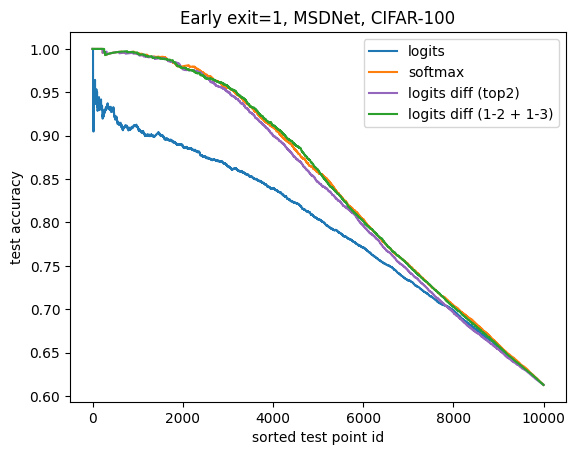

In [134]:
l = 0

plt.plot((targets_test == preds[l])[logits_test[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits')
plt.plot((targets_test == preds[l])[probs[l].max(dim=1).values.argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='softmax')
plt.plot((targets_test == preds[l])[(logits_test[l, :, :].max(dim=1).values - logits_test[l, :, :].sort(descending=True)[0][:, 1]).argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits diff (top2)', color='tab:purple')
plt.plot((targets_test == preds[l])[(_logits).argsort(descending=True).numpy()].int().numpy().cumsum() / np.arange(1, N + 1), label='logits diff (1-2 + 1-3)')
# add based on the ratio between top two logits
plt.xlabel('sorted test point id')
plt.ylabel('test accuracy')
plt.title(f'Early exit={l + 1}, MSDNet, CIFAR-100')
plt.legend()
plt.show()

## 11 Noise in the rest of logits

In [136]:
def sample_logits(r=5.):
    logits = np.concatenate([np.array([12., 10.]), np.random.uniform(-r, r, 98)])

    probs_ovr = np.maximum(logits, 0)
    probs_ovr /= np.sum(probs_ovr)

    # numerically stable softmax
    logits -= np.max(logits)
    probs_softmax = np.exp(logits) / np.sum(np.exp(logits))

    return probs_ovr, probs_softmax

In [137]:
probs_ovr_top, probs_softmax_top = [], []
for _ in range(1000):
    probs_ovr, probs_softmax = sample_logits()
    probs_ovr_top.append(np.max(probs_ovr))
    probs_softmax_top.append(np.max(probs_softmax))

probs_ovr_top = np.array(probs_ovr_top)
probs_softmax_top = np.array(probs_softmax_top)

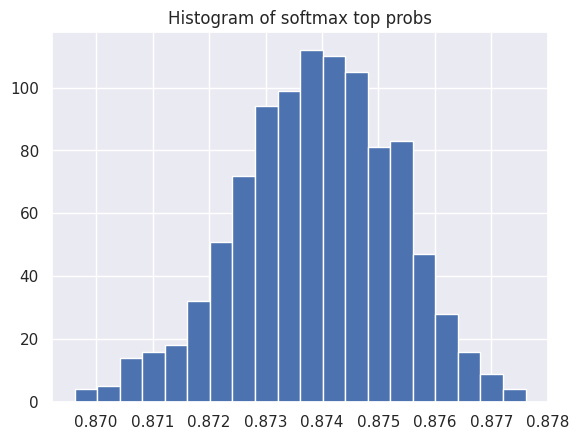

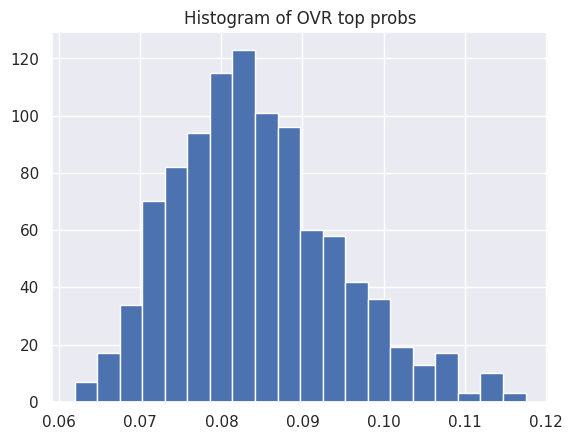

In [138]:
# plot histogram of softmax top probs

sns.set()

plt.hist(probs_softmax_top, bins=20)
plt.title("Histogram of softmax top probs")
plt.show()

plt.hist(probs_ovr_top, bins=20)
plt.title("Histogram of OVR top probs")
plt.show()


In [139]:
probs_softmax_top.mean(), probs_softmax_top.std(), probs_softmax_top.max() - probs_softmax_top.min()

(0.8739039078375157, 0.0013893779052877018, 0.007987034755875144)

In [140]:
probs_ovr_top.mean(), probs_ovr_top.std(), probs_ovr_top.max() - probs_ovr_top.min()

(0.08431626957556738, 0.010090536466469697, 0.055592485354478756)